## Markowitz Python

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
from scipy.optimize import minimize

In [3]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2022, 12, 31) 

In [4]:
# lista_acoes = ['WEGE3', 'LREN3', 'VALE3', 'PETR4', 'EQTL3', 'EGIE3']
# lista_acoes = [acao + '.SA' for acao in lista_acoes] 

lista_acoes = ['AAPL', 'NKE', 'GOOGL', 'AMZN']

precos = yf.download(lista_acoes, inicio, final)['Adj Close']
precos

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOGL,NKE
Date,,,,
2015-01-02,24.498688,15.426000,26.477501,43.225166
2015-01-05,23.808514,15.109500,25.973000,42.529243
2015-01-06,23.810753,14.764500,25.332001,42.279057
2015-01-07,24.144636,14.921000,25.257500,43.152397
2015-01-08,25.072321,15.023000,25.345501,44.148533
...,...,...,...,...
2022-12-23,131.299820,85.250000,89.230003,115.152924
2022-12-27,129.477585,83.040001,87.389999,116.450554
2022-12-28,125.504539,81.820000,86.019997,113.894905


In [5]:
retornos = precos.pct_change().apply(lambda x: np.log(1 + x)).dropna() #retorno logaritmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov() 

In [6]:
media_retornos

AAPL     0.000827
AMZN     0.000842
GOOGL    0.000598
NKE      0.000490
dtype: float64

In [7]:
matriz_cov

,AAPL,AMZN,GOOGL,NKE
AAPL,0.000356,0.000232,0.000216,0.000172
AMZN,0.000232,0.000436,0.000247,0.000164
GOOGL,0.000216,0.000247,0.000316,0.000165
NKE,0.000172,0.000164,0.000165,0.000348


In [8]:
numero_carteiras = 100000

vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)

tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos)
    
    tabela_pesos[k,: ] = pesos
    
    vetor_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(pesos, matriz_cov*252)))
    
    vetor_sharpe[k] = vetor_retornos_esperados[k] / vetor_volatilidades_esperadas[k]

In [9]:
tabela_pesos

array([[0.24546942, 0.33431885, 0.26025427, 0.15995745],
       [0.34569585, 0.20911879, 0.27889144, 0.16629392],
       [0.25596991, 0.00308054, 0.5343282 , 0.20662134],
       ...,
       [0.22734663, 0.36681815, 0.09333854, 0.31249668],
       [0.28601042, 0.28248274, 0.26513939, 0.16636746],
       [0.20962038, 0.34214119, 0.38978265, 0.05845578]])

In [11]:
indice_do_sharpe_maximo = vetor_sharpe.argmax()

In [12]:
print('Otimização de carteira - Markovitz')
print(f'--> {[lista_acoes[0], lista_acoes[1], lista_acoes[2], lista_acoes[3]]}')
print(f'--> {tabela_pesos[indice_do_sharpe_maximo]}')

Otimização de carteira - Markovitz
--> ['AAPL', 'NKE', 'GOOGL', 'AMZN']
--> [0.56611429 0.38318187 0.00397307 0.04673077]


In [13]:
tabela_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1
tabela_retornos_esperados_arit

array([0.19845514, 0.1959503 , 0.17351628, ..., 0.1946309 , 0.19722817,
       0.1998648 ])

In [14]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(), 
                                        tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1
    return retorno

def checando_soma_pesos(peso_teste):
    return np.sum(peso_teste) - 1 

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(peso_teste, matriz_cov * 252)))
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes)
limites = tuple([(0, 1) for ativo in lista_acoes]) 

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    
    restricoes = ({'type': 'eq', 'fun':checando_soma_pesos},
                 {'type': 'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites, 
                     constraints = restricoes)
    
    eixo_x_fronteira_eficiente.append(result['fun'])

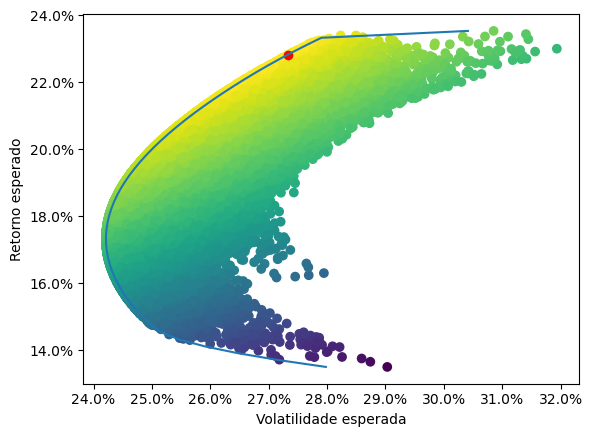

In [15]:
fig, ax = plt.subplots()

ax.scatter(vetor_volatilidades_esperadas, tabela_retornos_esperados_arit, c = vetor_sharpe)
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno esperado')
ax.scatter(vetor_volatilidades_esperadas[indice_do_sharpe_maximo], tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = 'red')
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente) 
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show() 

# RESUMO

In [41]:
print('Otimização de carteira - Markovitz')
print(f'--> {[lista_acoes[0], lista_acoes[1], lista_acoes[2], lista_acoes[3]]}')
print(f'--> {tabela_pesos[indice_do_sharpe_maximo]}')

Otimização de carteira - Markovitz
--> ['AAPL', 'NKE', 'GOOGL', 'AMZN']
--> [0.56611429 0.38318187 0.00397307 0.04673077]


In [38]:
retorno_ao_ano = float('{:.2f}'.format(tabela_retornos_esperados_arit[indice_do_sharpe_maximo] * 100))
print(f'Retorno anual: {retorno_ao_ano} %')

Retorno anual: 22.83 %


In [45]:
retorno_acumulado = ((1 + (retorno_ao_ano/100)) ** (8/1) - 1) * 100
retorno_acumulado = float('{:.2f}'.format(retorno_acumulado))
print(f'Retorno_acumulado no período: {retorno_acumulado} %')

Retorno_acumulado no período: 418.13 %
